In [23]:
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
#plt.style.use(['seaborn-pastel'])

In [24]:
# 从网站爬取的数据 里面有很多数据 包括每一个market maker设置的价差变化
with open('data/final_info_data1.json', 'r') as file:
    file = json.load(file)
#     data1 = file[0]
    data1 = file

#  下载的用户交易记录
df = pd.read_csv('data/icbs_derivatives_op-PyjkPu7rO_trades (1).csv')

In [25]:
all_user = pd.DataFrame()
for i in range(0,len(data1['players']['data'])):
    data = data1['players']['data'][i]
    data_role = data['role']
    data_log = data['rate_change_log']
    user_data = pd.DataFrame(data_log)
    user_data['role'] = data_role
    all_user=pd.concat([all_user,user_data])
        
all_user['time'] = pd.to_datetime(all_user['time'], unit='ms', utc=True)   
all_user['time'] = all_user['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
all_user['buy'] = all_user['buy'].astype(str).str.lstrip('0').str.pad(width=1, side='left', fillchar='0').astype(int)
all_user['sell'] = all_user['sell'].astype(str).str.lstrip('0').str.pad(width=1, side='left', fillchar='0').astype(int)
all_user['round'] = all_user['round'].astype(int)
all_user = all_user.reset_index(drop='True')

In [26]:
all_user

,role,buy,round,sell,time
0,diamonds,32,1,28,2024-02-22 18:08:51
1,diamonds,28,1,24,2024-02-22 18:09:05
2,diamonds,25,1,21,2024-02-22 18:09:28
3,diamonds,23,1,19,2024-02-22 18:09:32
4,diamonds,22,1,18,2024-02-22 18:09:40
...,...,...,...,...,...
698,clubs,6,23,3,2024-02-22 18:42:39
699,clubs,4,23,3,2024-02-22 18:42:40
700,clubs,6,24,5,2024-02-22 18:44:35
701,clubs,9,24,5,2024-02-22 18:44:37


In [27]:
all_user['role'].unique()

array(['diamonds', 'spades', 'hearts', 'clubs'], dtype=object)

In [28]:
def get_key_round(df,round_list=[6,11,16,21,26]):
#     获取每一个关键交易轮的timeid
    df = df.set_index('time').sort_index()
    df.index = pd.to_datetime(df.index)
    round_realse = []
    for i in round_list:
#         print(i)
        realse1= df[df['round']==i].index[0]
        round_realse.append(realse1)
    return round_realse

In [29]:
def get_role_data(all_user,role):
    df = all_user[all_user['role']==role]
    df = df.set_index('time').sort_index()
    df.index = pd.to_datetime(df.index)
        
    return df


In [30]:
def plot_buy_sell(df,x_positions,title='example'):
    plt.figure(figsize = (10,6))
    plt.plot(df['buy'],label='Bid')
    plt.plot(df['sell'], label = 'Ask')
    plt.legend()

    max_price = max(df['buy'].astype(int).max(), df['sell'].astype(int).max())

    label = 1
    for i in x_positions:
        label += 5
        plt.axvline(x=i, color='gray', linestyle='--')  # 红色虚线
        plt.text(i, max_price * 0.95, f'Round {label}', rotation=0, horizontalalignment='center')

    plt.title(f'{title} ')
    plt.xlabel('Time')
    plt.ylabel('Trade Prices')
    plt.savefig(f'data/plot/{title}.png')
    plt.show()

In [31]:
round_realse = get_key_round(all_user,round_list=[6,11,16,21,26])

In [32]:
diamonds= get_role_data(all_user,'diamonds')
spades= get_role_data(all_user,'spades')
hearts= get_role_data(all_user,'hearts')
clubs= get_role_data(all_user,'clubs')

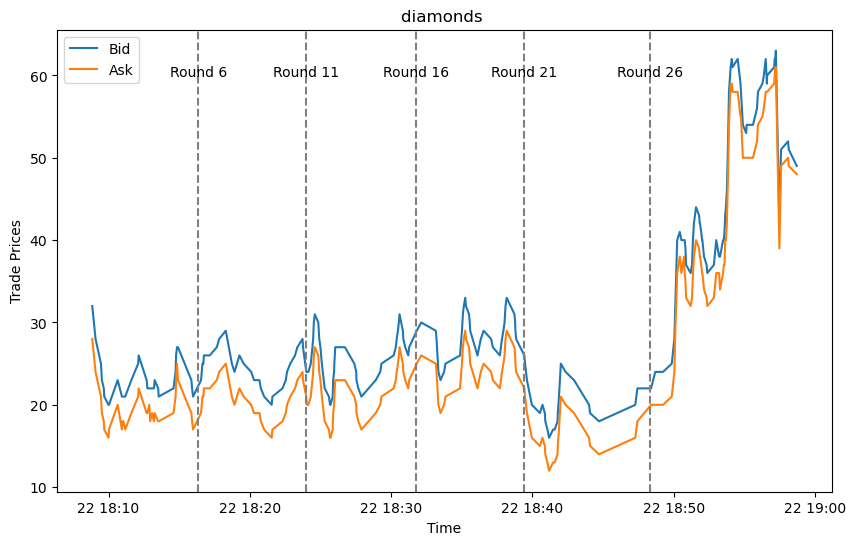

In [33]:
plot_buy_sell(diamonds,round_realse,title='diamonds')

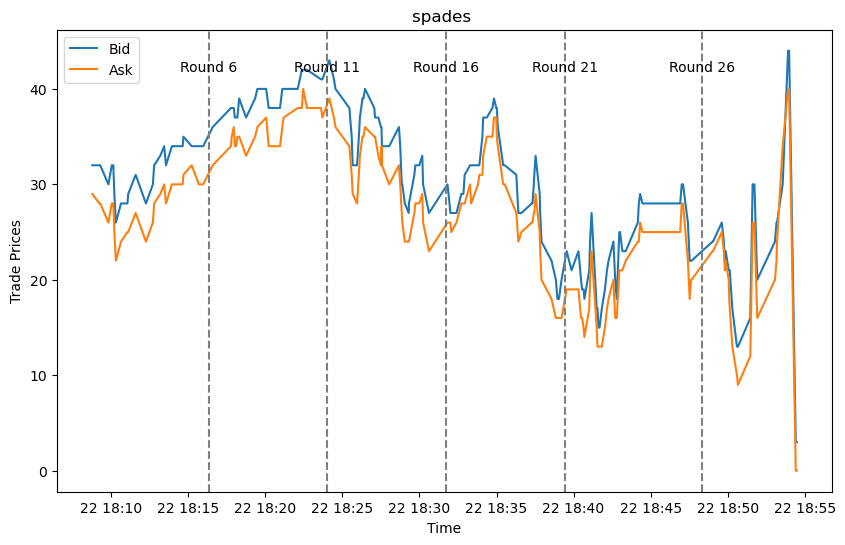

In [34]:
plot_buy_sell(spades,round_realse,title='spades')

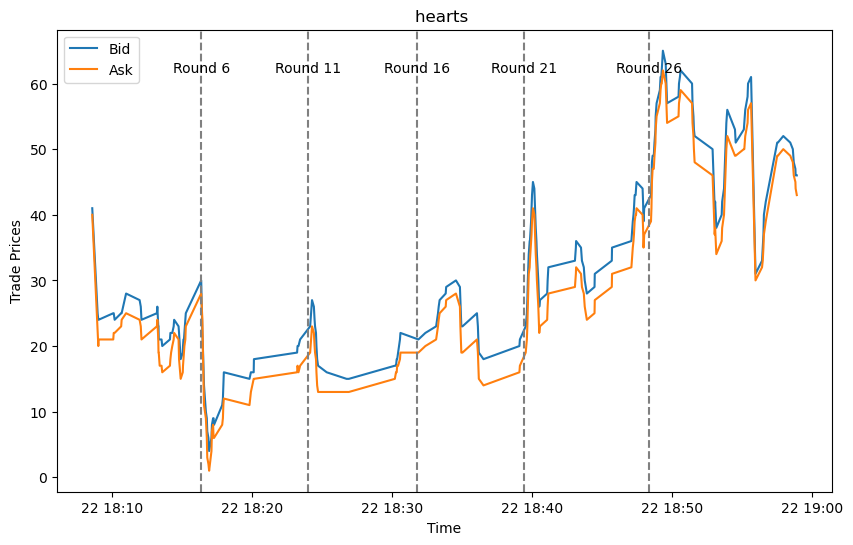

In [35]:
plot_buy_sell(hearts,round_realse,title='hearts')

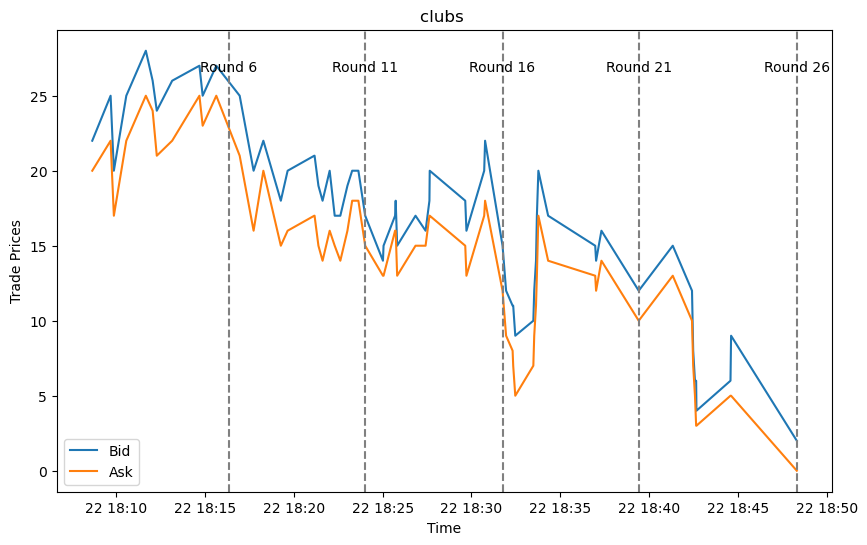

In [36]:
plot_buy_sell(clubs,round_realse,title='clubs')


In [37]:
clubs

,role,buy,round,sell
time,,,,
2024-02-22 18:08:39,clubs,22,1,20
2024-02-22 18:09:41,clubs,25,1,22
2024-02-22 18:09:52,clubs,20,1,17
2024-02-22 18:10:34,clubs,25,2,22
2024-02-22 18:11:40,clubs,28,3,25
...,...,...,...,...
2024-02-22 18:42:39,clubs,6,23,3
2024-02-22 18:42:40,clubs,4,23,3
2024-02-22 18:44:35,clubs,6,24,5


## 用户交易数据 

###  market maker的价差

In [38]:
all_user['spread'] = all_user['buy'] - all_user['sell']

### 每一个market maker设置的价差

In [39]:
all_user.groupby('role')['spread'].mean()

role
clubs       2.640625
diamonds    3.755365
hearts      3.140969
spades      3.195531
Name: spread, dtype: float64

###  所有的市场上的交易价差

In [40]:
all_user['spread'].mean()

3.3129445234708395

In [41]:
df

,game_id,market,actor,actor_id,price,round,type,date,time
0,op-PyjkPu7rO,diamonds,xin,dc16afcd-8787-45fd-8921-a531ec0cefa1,48,32,sell,22/2/2024,18:58:64
1,op-PyjkPu7rO,hearts,xin,dc16afcd-8787-45fd-8921-a531ec0cefa1,44,32,sell,22/2/2024,18:58:725
2,op-PyjkPu7rO,hearts,jacky,f6ee3ebc-f691-4e17-9b78-a22488bdaa2e,44,32,sell,22/2/2024,18:58:664
3,op-PyjkPu7rO,hearts,Yimeng,6c314841-1137-4f22-8285-53b02057ee8f,46,32,buy,22/2/2024,18:58:486
4,op-PyjkPu7rO,diamonds,xin,dc16afcd-8787-45fd-8921-a531ec0cefa1,48,32,sell,22/2/2024,18:58:935
...,...,...,...,...,...,...,...,...,...
2520,op-PyjkPu7rO,spades,Yimeng,6c314841-1137-4f22-8285-53b02057ee8f,30,1,buy,22/2/2024,18:8:305
2521,op-PyjkPu7rO,clubs,Yimeng,6c314841-1137-4f22-8285-53b02057ee8f,24,1,sell,22/2/2024,18:8:343
2522,op-PyjkPu7rO,spades,Yimeng,6c314841-1137-4f22-8285-53b02057ee8f,30,1,buy,22/2/2024,18:8:700
2523,op-PyjkPu7rO,spades,xin,dc16afcd-8787-45fd-8921-a531ec0cefa1,24,1,sell,22/2/2024,18:8:468


###  交易量

In [42]:
df.groupby(['actor','market'])['game_id'].count()

actor   market  
Ronald  clubs       142
        diamonds    283
        spades      289
Yimeng  clubs        61
        hearts       95
        spades       75
jacky   clubs        74
        diamonds    125
        hearts      272
xin     diamonds    283
        hearts      298
        spades      528
Name: game_id, dtype: int64

###  针对每一个market maker的交易数据

In [43]:
df.groupby(['market','type'])['game_id'].count()

market    type
clubs     buy     187
          sell     90
diamonds  buy     319
          sell    372
hearts    buy     325
          sell    340
spades    buy     455
          sell    437
Name: game_id, dtype: int64

### 每个用户在每一个市场的交易平均价格

In [44]:
df.groupby(['actor','market','type'])['price'].mean()

actor   market    type
Ronald  clubs     buy     14.860294
                  sell    14.500000
        diamonds  buy     34.604167
                  sell    29.080214
        spades    buy     26.924242
                  sell    22.520000
Yimeng  clubs     buy     15.111111
                  sell    15.750000
        hearts    buy     27.885246
                  sell    31.000000
        spades    buy     32.552632
                  sell    27.918919
jacky   clubs     buy     18.785714
                  sell    15.250000
        diamonds  buy     30.546667
                  sell    33.000000
        hearts    buy     31.444444
                  sell    40.719512
xin     diamonds  buy     28.783784
                  sell    38.400000
        hearts    buy     31.884615
                  sell    35.323944
        spades    buy     24.326797
                  sell    27.370667
Name: price, dtype: float64